# Labeling
pyclesperanto comes with multiple labeling operations. Those operations turn images of other kind (intensity images or binary images) into label images, where each segmented object has a label value that identifies it. All pixels that belong to the object have that value.

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle

cle.select_device("RTX")

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

For demonstration purposes we load an intensity image and create a binary image.

cl.OCLArray([[ 40.,  32.,  24., ..., 216., 200., 200.],
       [ 56.,  40.,  24., ..., 232., 216., 216.],
       [ 64.,  48.,  24., ..., 240., 232., 232.],
       ...,
       [ 72.,  80.,  80., ...,  48.,  48.,  48.],
       [ 80.,  80.,  80., ...,  48.,  48.,  48.],
       [ 96.,  88.,  80., ...,  48.,  48.,  48.]], dtype=float32)
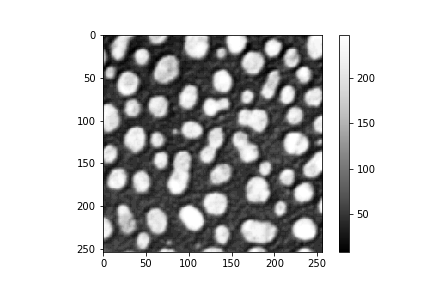
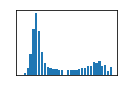

In [2]:
raw_image = cle.asarray(imread("../../data/blobs.tif"))
raw_image

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
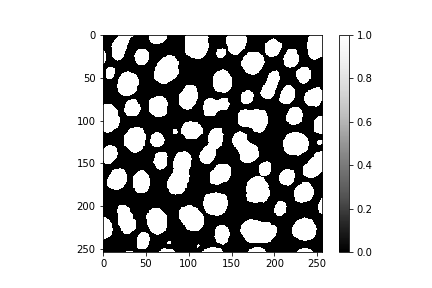
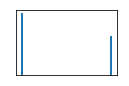

In [3]:
binary_image = raw_image > 100
binary_image

## Creating label images
### Connected component labeling
The most common labeling algorithm is [connected component labeling (CCL)](https://en.wikipedia.org/wiki/Connected-component_labeling). This algorithm consumes a binary image and produces a label image so that neighboring white pixels in the binary image are combined to labels in the label image.

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
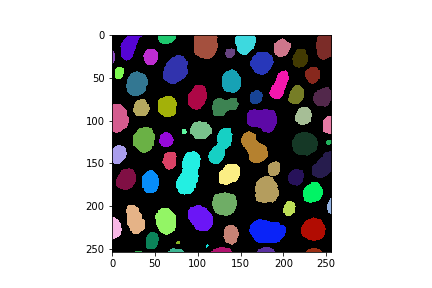

In [4]:
ccl_image_box = cle.connected_components_labeling_box(binary_image)
ccl_image_box

pyclesperanto has two functions which perform connected component labeling and take different pixel neighborhoods (a.k.a. footprint or structuring elements) into account.

cl.OCLArray([[ 0,  0,  0, ..., 63, 63, 63],
       [ 0,  0,  0, ..., 63, 63, 63],
       [ 0,  0,  0, ..., 63, 63, 63],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
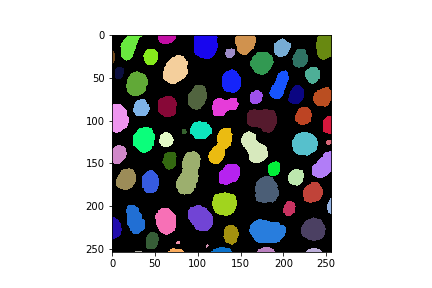

In [5]:
ccl_image_diamond = cle.connected_components_labeling_diamond(binary_image)
ccl_image_diamond

The difference between these two might hard to spot, but is easy to measure:

In [6]:
print("Number of objects in Diamond CCL result:", ccl_image_diamond.max())

Number of objects in Diamond CCL result: 66.0


In [7]:
print("Number of objects in Box CCL result:", ccl_image_box.max())

Number of objects in Box CCL result: 65.0


### Gauss-Otsu-Labeling
We often use image blurring, e.g. using a [Gaussian blur](), [Otus's thresholding method]() and CCL in combination. Thus, pyclesperanto has a function which combines these operations and make them easier accessible. The parameter `outline_sigma` allows tuning the smoothness of the outline of the labeled objects. When increasing it, also small objects may disappear.

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
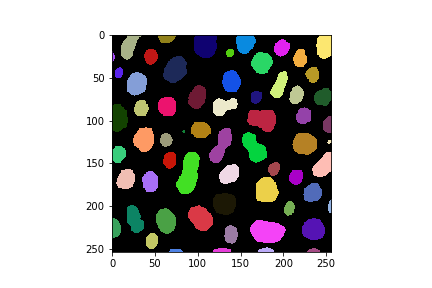

In [8]:
gol1 = cle.gauss_otsu_labeling(raw_image, outline_sigma=1)
gol1

cl.OCLArray([[ 0,  0,  0, ..., 52, 52, 52],
       [ 0,  0,  0, ..., 52, 52, 52],
       [ 0,  0,  0, ..., 52, 52, 52],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
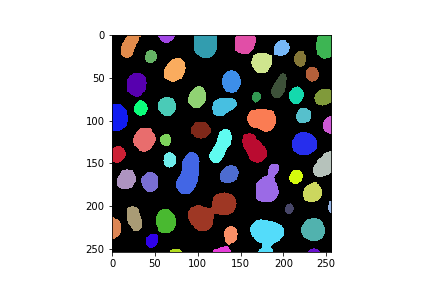

In [9]:
gol5 = cle.gauss_otsu_labeling(raw_image, outline_sigma=5)
gol5

### Eroded Otsu Labeling
When touching objects are connected, it may make sense to erode a binary image before passing it to CCL. Afterwards, the labels can be dilated again so that the original binary image is filled with labels. This algorithm was suggested by Jan Brocher ([Biovoxxel](https://www.biovoxxel.de/)). Also this algorithm offers the parameter `outline_sigma` as explained above. Furthermore, you can control the number of binary erosion operations that are applied by changing the parameter `number_of_erosions`. Large values of this parameter can make objects disappear as well.

cl.OCLArray([[ 0,  0,  0, ..., 56, 56, 56],
       [ 0,  0,  0, ..., 56, 56, 56],
       [ 0,  0,  0, ..., 56, 56, 56],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
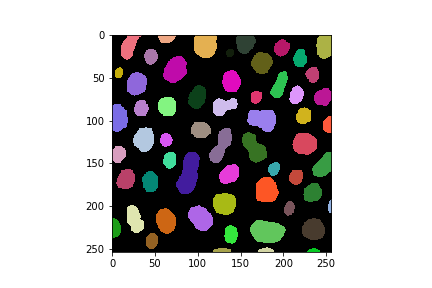

In [10]:
eol3 = cle.eroded_otsu_labeling(raw_image, outline_sigma=1, number_of_erosions=3)
eol3

cl.OCLArray([[ 0,  0,  0, ..., 51, 51, 51],
       [ 0,  0,  0, ..., 51, 51, 51],
       [ 0,  0,  0, ..., 51, 51, 51],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
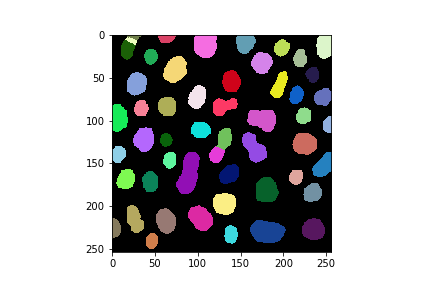

In [11]:
eol5 = cle.eroded_otsu_labeling(raw_image, outline_sigma=1, number_of_erosions=5)
eol5

### Voronoi-Otsu-Labeling
Another common approach is blurring the raw image, detecting maxima and using a binary watershed to flood a corresponding binary image with label values. Results are supposed to be similar to a binary image that has been processed by ImageJ's binary Watershed algorithm before it is passed to CCL. The algorithm has a parameter `outline_sigma` as explained above. Furthermore, the `spot_sigma` parameter allows to tune how distant local maxima are in the initial detection step.

cl.OCLArray([[  0,   0,   0, ..., 147, 147, 147],
       [  0,   0,   0, ..., 147, 147, 147],
       [  0,   0,   0, ..., 147, 147, 147],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint32)
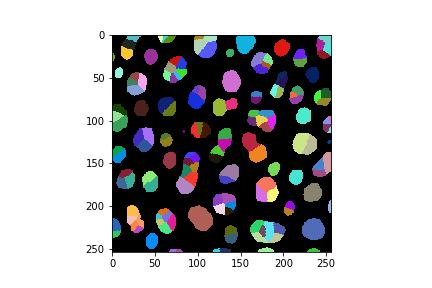

In [12]:
vol1 = cle.voronoi_otsu_labeling(raw_image, outline_sigma=1, spot_sigma=1)
vol1

cl.OCLArray([[ 0,  0,  0, ..., 65, 65, 65],
       [ 0,  0,  0, ..., 65, 65, 65],
       [ 0,  0,  0, ..., 65, 65, 65],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
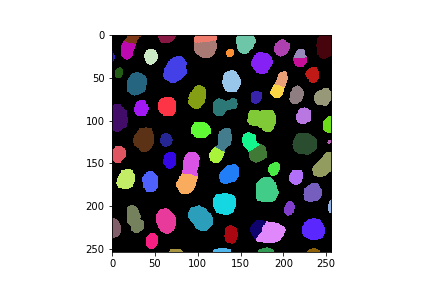

In [13]:
vol32 = cle.voronoi_otsu_labeling(raw_image, outline_sigma=1, spot_sigma=3.2)
vol32

## Post-processing label images
### Voronoi tesselation
Starting at different label or binary images, we can partionion an entire image into labels using Voronoi tesselation.

cl.OCLArray([[ 9,  9,  9, ..., 65, 65, 65],
       [ 7,  9,  9, ..., 65, 65, 65],
       [ 7,  7,  7, ..., 65, 65, 65],
       ...,
       [ 2,  2,  2, ..., 63, 63, 63],
       [ 2,  2,  2, ..., 63, 63, 63],
       [ 2,  2,  2, ..., 63, 63, 63]], dtype=uint32)
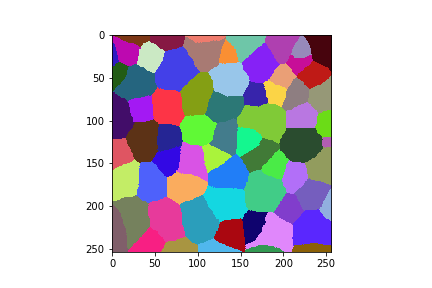

In [14]:
tesselated_image = cle.extend_labeling_via_voronoi(vol32)
tesselated_image

Similarly, starting from a binary image, we can label the objects using connected component labeling and then partion the image.

cl.OCLArray([[ 7,  7,  7, ..., 62, 62, 62],
       [ 7,  7,  7, ..., 62, 62, 62],
       [ 7,  7,  7, ..., 62, 62, 62],
       ...,
       [ 4,  4,  4, ..., 59, 59, 59],
       [ 4,  4,  4, ..., 59, 59, 59],
       [ 4,  4,  4, ..., 59, 59, 59]], dtype=uint32)
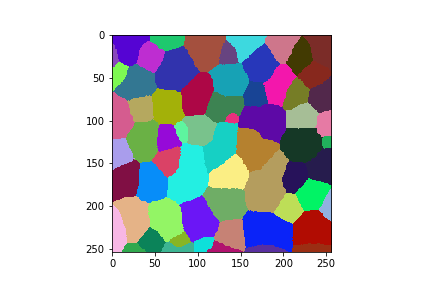

In [15]:
partioned_image = cle.voronoi_labeling(binary_image)
partioned_image

### Exclude small/large labels
You can exclude small and large labels using dedicated operations. It is also possible to select a size range of labels to keep or remove.

cl.OCLArray([[ 0,  0,  0, ..., 33, 33, 33],
       [ 0,  0,  0, ..., 33, 33, 33],
       [ 0,  0,  0, ..., 33, 33, 33],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
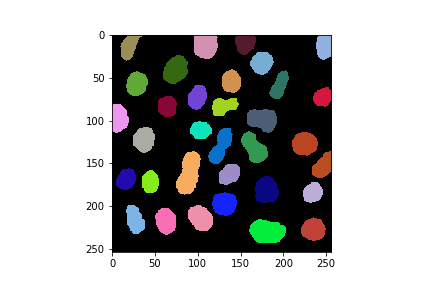

In [16]:
large_labels = cle.exclude_small_labels(ccl_image_diamond, maximum_size=350)
large_labels

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
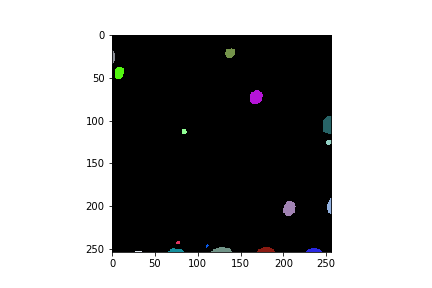

In [17]:
small_labels = cle.exclude_large_labels(ccl_image_diamond, minimum_size=200)
small_labels

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
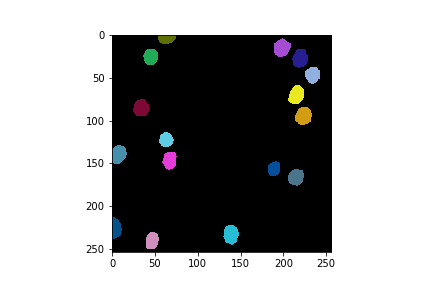

In [18]:
medium_sized_labels = cle.exclude_labels_out_of_size_range(ccl_image_diamond, minimum_size=200, maximum_size=350)
medium_sized_labels

### Combine label images
You can also combine label images.

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
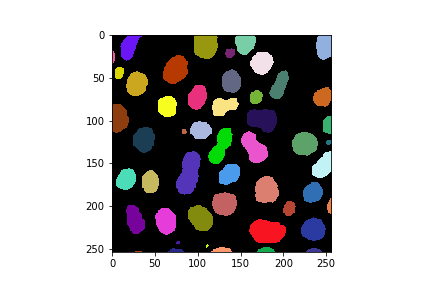

In [19]:
combined_labels = cle.combine_labels(small_labels, large_labels)
combined_labels

### Dilating label images
Dilating label images, is similar to a maximum filter. The only difference is that labels don't overwrite each other.

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
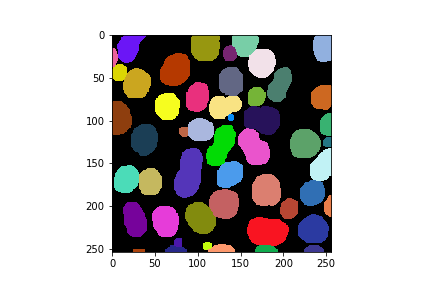

In [20]:
dilated_labels_3 = cle.dilate_labels(combined_labels, radius=3)
dilated_labels_3

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
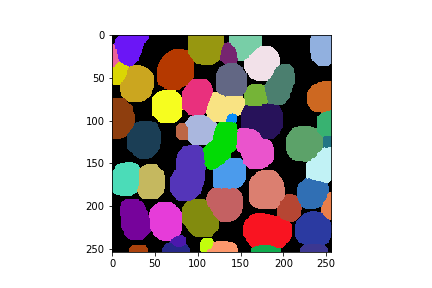

In [21]:
dilated_labels_7 = cle.dilate_labels(combined_labels, radius=7)
dilated_labels_7

### Eroding label images
When eroding label images, basically two options exist: Erode labels using a minimum-filter after introducing a background-pixel between labels, and eroding the labels while keeping their connected regions connected.

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
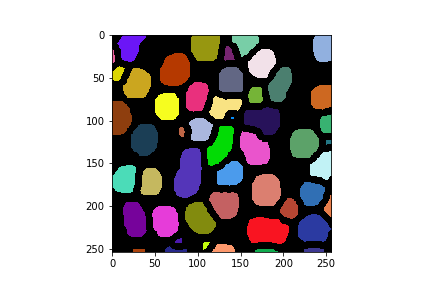

In [22]:
eroded_labels_3 = cle.erode_labels(dilated_labels_7, radius=3)
eroded_labels_3

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
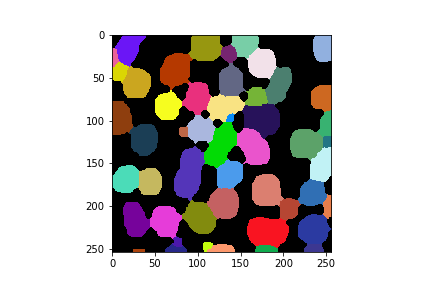

In [23]:
eroded_connected_labels_3 = cle.erode_connected_labels(dilated_labels_7, radius=3)
eroded_connected_labels_3

### Label opening
In a similar way, labels can also be opened. Note: Depending on the radius, small labels may disappear.

opened_labels_1 = cle.opening_labels(combined_labels, radius=1)

cle.imshow(opened_labels_1, labels=True)

cl.OCLArray([[ 0,  0,  0, ..., 36, 36, 36],
       [ 0,  0,  0, ..., 36, 36, 36],
       [ 0,  0,  0, ..., 36, 36, 36],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
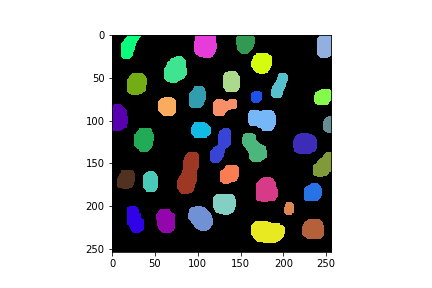

In [24]:
opened_labels_5 = cle.opening_labels(combined_labels, radius=5)
opened_labels_5

### Label closing
Analogously, an operation for closing label images exists.

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
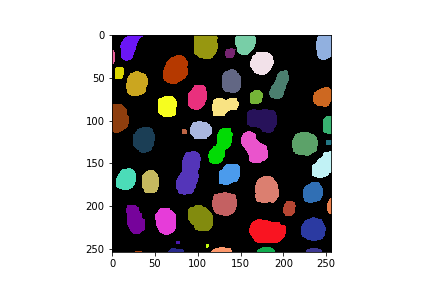

In [25]:
closed_labels_1 = cle.closing_labels(combined_labels, radius=1)
closed_labels_1

cl.OCLArray([[ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
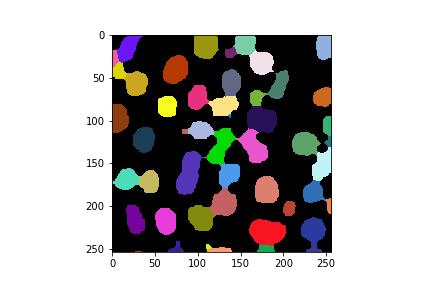

In [26]:
closed_labels_5 = cle.closing_labels(combined_labels, radius=5)
closed_labels_5

### Excluding labels according to other parameters
We can also exclude labels in a label image according to other parameters, e.g. using shape. Therefore, we need a parametric image where the pixels in the label correspond to the parameter we want to consider for excluding labels.

cl.OCLArray([[0.       , 0.       , 0.       , ..., 1.8315369, 1.8315369,
        1.8315369],
       [0.       , 0.       , 0.       , ..., 1.8315369, 1.8315369,
        1.8315369],
       [0.       , 0.       , 0.       , ..., 1.8315369, 1.8315369,
        1.8315369],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)
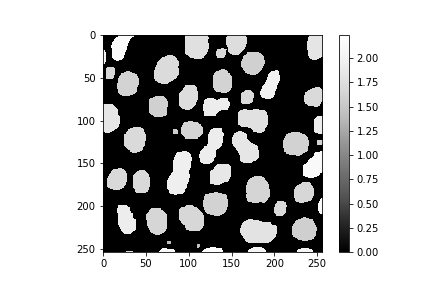
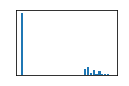

In [27]:
shape_parametric_image = cle.extension_ratio_map(closed_labels_1)
shape_parametric_image

cl.OCLArray([[ 0,  0,  0, ..., 19, 19, 19],
       [ 0,  0,  0, ..., 19, 19, 19],
       [ 0,  0,  0, ..., 19, 19, 19],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
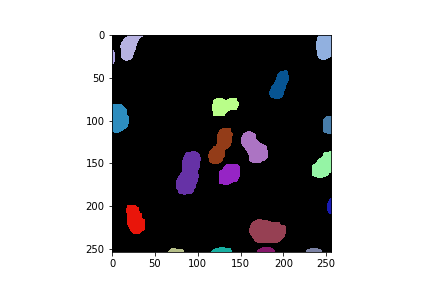

In [28]:
minimum_extension_ratio = 1.8
maximum_extension_ratio = 100
elongated_labels = cle.exclude_labels_with_map_values_out_of_range(
    shape_parametric_image, 
    closed_labels_1, 
    minimum_value_range=minimum_extension_ratio,
    maximum_value_range=maximum_extension_ratio,
)
elongated_labels

## Other operations
### Label borders
Label border images can be derived as label image and as binary image.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
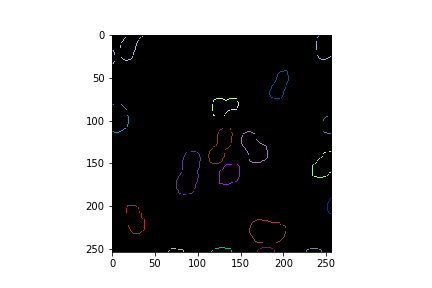

In [29]:
label_border_image = cle.reduce_labels_to_label_edges(elongated_labels)
label_border_image

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
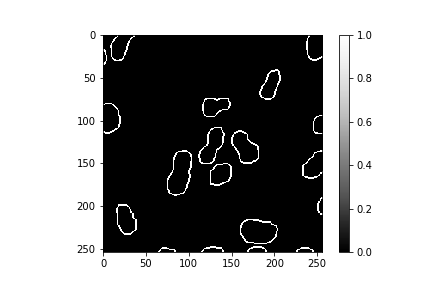
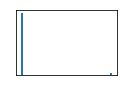

In [30]:
binary_border_image = cle.detect_label_edges(elongated_labels)
binary_border_image

### Label centroids
Labels can also be reduced to their centroids.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
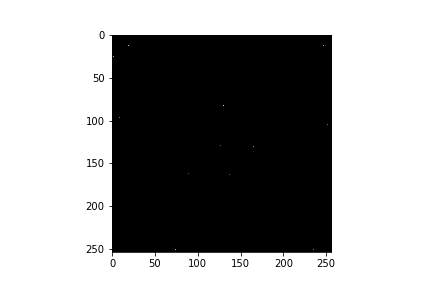

In [31]:
label_centroids_image = cle.reduce_labels_to_centroids(elongated_labels)
label_centroids_image

Just for visualization purposes, it may make sense to apply a label dilation to this image.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
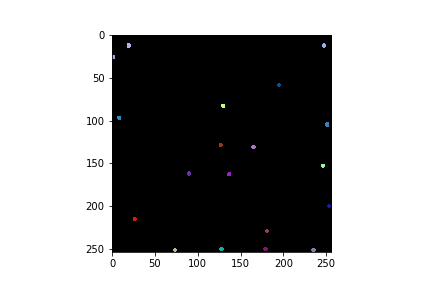

In [32]:
visualization_label_centroids_image = cle.dilate_labels(label_centroids_image, radius=2)
visualization_label_centroids_image